# Imports

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import spacy
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap

In [ ]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("maxent_ne_chunker_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


True

# Data Preparation

## Loading

In this step I load the dataset and prepare the labels (i.e map ("0", "1") -> 0 and ("2" ,"3", "4") -> 1)

In [ ]:
DATA_URL = "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"

columns = ["par_id", "art_id", "keyword", "country_code", "text", "label"]

df = pd.read_csv(
    DATA_URL,
    sep="\t",
    header=None,
    names=columns,
    engine="python",          # needed because of messy text field
    quoting=csv.QUOTE_NONE    # treat quotes as normal text
)


In [ ]:
print("Shape:", df.shape)
print("Types:", df.dtypes)
print("First 5 rows:", df.head(1))
df["label"].value_counts()

Shape: (10472, 6)
Types: par_id           object
art_id           object
keyword          object
country_code     object
text             object
label           float64
dtype: object
First 5 rows:                                               par_id art_id keyword  \
0  ----------------------------------------------...   None    None   

  country_code  text  label  
0         None  None    NaN  


,count
label,
0.0,8529
1.0,947
3.0,458
4.0,391
2.0,144


## Cleaning

### Fixing Structural Problems

In [ ]:
# Drop empty values
prev_len = len(df)
df = df.dropna(subset=["text", "label"])
df = df[df["text"].astype(str).str.strip().ne("")]
print(f"Dropped {prev_len - len(df)} empty values")

Dropped 4 empty values


In [ ]:
# Add binary labels
df["binary_label"] = df["label"].apply(lambda x: 0 if x in [0, 1] else 1)
df["binary_label"].value_counts()

,count
binary_label,
0,9475
1,993


### Artifacts Removal

In [ ]:
# ==========================================
# HTML tags and newlines removal
# ==========================================

def clean_raw_text(text):
    if text is None:
        return ""

    text = str(text)

    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # remove HTML entities like &amp;
    text = re.sub(r"&[a-z]+;", " ", text)

    # remove newline / tab characters
    text = re.sub(r"[\n\r\t]", " ", text)

    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


# apply cleaning
df["text_clean"] = df["text"].apply(clean_raw_text)


# ---------- concise report ----------
changed = (df["text"] != df["text_clean"]).sum()
total = len(df)

html = df["text"].astype(str).str.contains(r"<.*?>", regex=True).sum()
entities = df["text"].astype(str).str.contains(r"&[a-z]+;", regex=True).sum()
newlines = df["text"].astype(str).str.contains(r"[\n\r\t]", regex=True).sum()

print(f"Artifact cleaning modified {changed}/{total} rows ({changed/total:.1%}).")
print(f"HTML tags: {html} | HTML entities: {entities} | Newlines/tabs: {newlines}")
print("Sanity:", "OK" if changed > 0 else "No effect")


# preview
df[["text", "text_clean"]].head()

Artifact cleaning modified 469/10468 rows (4.5%).
HTML tags: 401 | HTML entities: 78 | Newlines/tabs: 0
Sanity: OK


,text,text_clean
3,"We 're living in times of absolute insanity , ...","We 're living in times of absolute insanity , ..."
4,"In Libya today , there are countless number of...","In Libya today , there are countless number of..."
5,"""White House press secretary Sean Spicer said ...","""White House press secretary Sean Spicer said ..."
6,Council customers only signs would be displaye...,Council customers only signs would be displaye...
7,""""""" Just like we received migrants fleeing El ...",""""""" Just like we received migrants fleeing El ..."


In [ ]:
# ==========================================
# Quote normalization (including repeated quotes)
# ==========================================

# detect non-standard or repeated quotes
QUOTE_REGEX = r"[“”‘’´`]|``|''|\"{2,}"

def normalize_quotes(text):
    if text is None:
        return ""

    text = str(text)

    # convert curly quotes to ASCII
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("‘", "'").replace("’", "'")
    text = text.replace("´", "'").replace("`", "'")

    # normalize repeated quotes: """ → "
    text = re.sub(r"\"{2,}", '"', text)
    text = re.sub(r"'{2,}", "'", text)

    return text


# detect BEFORE normalization
total = len(df)
quote_rows = df["text_clean"].astype(str).str.contains(QUOTE_REGEX, regex=True).sum()

# apply normalization
df["text_clean"] = df["text_clean"].apply(normalize_quotes)

print(f"Quotes normalized in {quote_rows}/{total} rows ({quote_rows/total:.1%}).")
print("Sanity:", "OK" if quote_rows > 0 else "No quote artifacts detected")

df[["text_clean"]].head()

Quotes normalized in 2599/10468 rows (24.8%).
Sanity: OK


,text_clean
3,"We 're living in times of absolute insanity , ..."
4,"In Libya today , there are countless number of..."
5,"""White House press secretary Sean Spicer said ..."
6,Council customers only signs would be displaye...
7,""" Just like we received migrants fleeing El Sa..."


In [ ]:
# ==========================================
# Remove spaces before punctuation
# e.g. "word , word ." → "word, word."
# ==========================================

SPACE_BEFORE_PUNCT_REGEX = r"\s+([.,!?;:%])"

def remove_space_before_punct(text):
    if text is None:
        return ""

    text = str(text)

    # remove spaces before punctuation
    text = re.sub(SPACE_BEFORE_PUNCT_REGEX, r"\1", text)

    return text


# detect BEFORE applying
total = len(df)
affected_rows = df["text_clean"].astype(str).str.contains(SPACE_BEFORE_PUNCT_REGEX, regex=True).sum()

# apply normalization
df["text_clean"] = df["text_clean"].apply(remove_space_before_punct)

print(f"Spacing normalized in {affected_rows}/{total} rows ({affected_rows/total:.1%}).")
print("Sanity:", "OK" if affected_rows > 0 else "No spacing issues detected")

df[["text_clean"]].head()

Spacing normalized in 10183/10468 rows (97.3%).
Sanity: OK


/tmp/ipython-input-3350969576.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  affected_rows = df["text_clean"].astype(str).str.contains(SPACE_BEFORE_PUNCT_REGEX, regex=True).sum()


,text_clean
3,"We 're living in times of absolute insanity, a..."
4,"In Libya today, there are countless number of ..."
5,"""White House press secretary Sean Spicer said ..."
6,Council customers only signs would be displaye...
7,""" Just like we received migrants fleeing El Sa..."


In [ ]:
# ==========================================
# URL & Email normalization
# Replace with placeholders: <URL>, <EMAIL>
# ==========================================

URL_REGEX = r"(https?://\S+|www\.\S+)"
EMAIL_REGEX = r"\b[\w\.-]+@[\w\.-]+\.\w+\b"

def replace_urls_emails(text):
    if text is None:
        return ""

    text = str(text)

    # replace URLs
    text = re.sub(URL_REGEX, " <URL> ", text)

    # replace emails
    text = re.sub(EMAIL_REGEX, " <EMAIL> ", text)

    # collapse whitespace after replacement
    text = re.sub(r"\s+", " ", text).strip()

    return text


# apply on already cleaned text
df["text_clean"] = df["text_clean"].apply(replace_urls_emails)


# Report changes
total = len(df)

urls = df["text"].astype(str).str.contains(URL_REGEX, regex=True).sum()
emails = df["text"].astype(str).str.contains(EMAIL_REGEX, regex=True).sum()

print(f"URLs replaced in {urls}/{total} rows ({urls/total:.1%}).")
print(f"Emails replaced in {emails}/{total} rows ({emails/total:.1%}).")
print("Sanity:", "OK" if (urls + emails) > 0 else "No URLs/emails detected")


# preview
df[["text_clean"]].head()


URLs replaced in 9/10468 rows (0.1%).
Emails replaced in 1/10468 rows (0.0%).
Sanity: OK


/tmp/ipython-input-1851820931.py:34: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  urls = df["text"].astype(str).str.contains(URL_REGEX, regex=True).sum()


,text_clean
3,"We 're living in times of absolute insanity, a..."
4,"In Libya today, there are countless number of ..."
5,"""White House press secretary Sean Spicer said ..."
6,Council customers only signs would be displaye...
7,""" Just like we received migrants fleeing El Sa..."


## Tokenization

Here I split the text into tokens using `punkt` from `ntlk`.
I also remove the HTML tags and newlines not to confuse the tokenizer.

In [ ]:
# ==========================================
# Tokenization (based on text_clean)
# ==========================================

def tokenize_basic(text):
    return word_tokenize(text)

df["tokens"] = df["text_clean"].apply(tokenize_basic)

df[["text_clean", "tokens"]].head()


,text_clean,tokens
3,"We 're living in times of absolute insanity, a...","[We, 're, living, in, times, of, absolute, ins..."
4,"In Libya today, there are countless number of ...","[In, Libya, today, ,, there, are, countless, n..."
5,"""White House press secretary Sean Spicer said ...","[``, White, House, press, secretary, Sean, Spi..."
6,Council customers only signs would be displaye...,"[Council, customers, only, signs, would, be, d..."
7,""" Just like we received migrants fleeing El Sa...","[``, Just, like, we, received, migrants, fleei..."


# Statistical Profiling

binary_label
0    9475
1     993
Name: count, dtype: int64


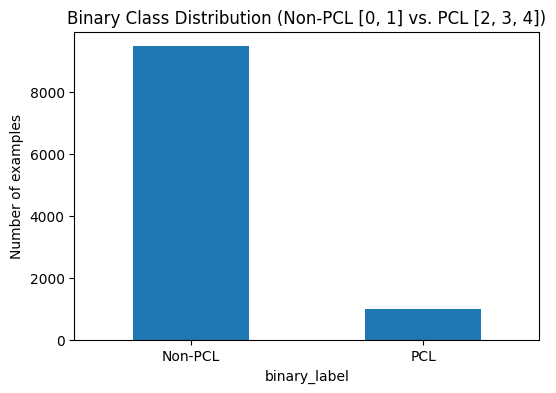

label
0    8528
1     947
2     144
3     458
4     391
Name: count, dtype: int64


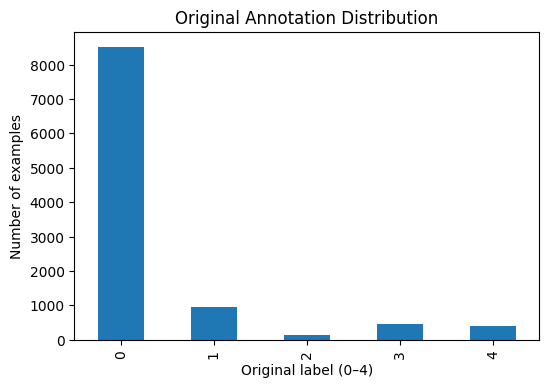

Binary label counts:
binary_label
0    9475
1     993
Name: count, dtype: int64

Original label counts:


In [ ]:
# Labels visualization
# Add binary labels
df["binary_label"] = df["label"].apply(lambda x: 0 if x in [0, 1] else 1)

# Cast labels to int
df["label"] = df["label"].astype(int)

# ---------- Plot 1: Binary label distribution ----------
binary_counts = df["binary_label"].value_counts().sort_index()
print(binary_counts)
plt.figure(figsize=(6,4))
binary_counts.plot(kind="bar")
plt.xticks([0, 1], ["Non-PCL", "PCL"], rotation=0)
plt.ylabel("Number of examples")
plt.title("Binary Class Distribution (Non-PCL [0, 1] vs. PCL [2, 3, 4])")
plt.show()

# ---------- Plot 2: Original label distribution ----------
original_counts = df["label"].value_counts().sort_index()
print(original_counts)
plt.figure(figsize=(6,4))
original_counts.plot(kind="bar")
plt.xlabel("Original label (0–4)")
plt.ylabel("Number of examples")
plt.title("Original Annotation Distribution")
plt.show()

# Sanity printout
print("Binary label counts:")
print(binary_counts)

print("\nOriginal label counts:")
#print(original_counts)

In [ ]:
# ==========================================
# Outlier diagnostics: token-length stats
# ==========================================

token_lens = df["tokens"].apply(len)

def length_summary(s):
    return pd.Series({
        "n": s.shape[0],
        "min": int(s.min()),
        "p50": int(s.quantile(0.50)),
        "p90": int(s.quantile(0.90)),
        "p95": int(s.quantile(0.95)),
        "p99": int(s.quantile(0.99)),
        "max": int(s.max()),
        "mean": float(s.mean()),
    })

print("Overall token-length summary:")
display(length_summary(token_lens))

print("\nToken-length summary by class:")
display(df.groupby("binary_label")["tokens"].apply(lambda x: length_summary(x.apply(len))))

# how many exceed common transformer limits
thresholds = [128, 256, 512]
rows = []
for t in thresholds:
    rows.append({
        "threshold": t,
        "overall_>=t": int((token_lens >= t).sum()),
        "pcl_>=t": int((df.loc[df["binary_label"] == 1, "tokens"].apply(len) >= t).sum()),
        "non_pcl_>=t": int((df.loc[df["binary_label"] == 0, "tokens"].apply(len) >= t).sum()),
    })

display(pd.DataFrame(rows))


Overall token-length summary:


,0
n,10468.000000
min,1.000000
p50,42.000000
p90,84.000000
p95,102.000000
p99,142.000000
max,912.000000
mean,48.644631



Token-length summary by class:


binary_label      
0             n       9475.000000
              min        1.000000
              p50       42.000000
              p90       83.000000
              p95      101.000000
              p99      142.000000
              max      912.000000
              mean      48.099736
1             n        993.000000
              min        6.000000
              p50       47.000000
              p90       90.000000
              p95      113.000000
              p99      146.000000
              max      512.000000
              mean      53.843907
Name: tokens, dtype: float64

,threshold,overall_>=t,pcl_>=t,non_pcl_>=t
0,128,190,27,163
1,256,6,1,5
2,512,2,1,1


In [ ]:
# Vocabulary size (unique words)
all_tokens = [token.lower() for tokens in df["tokens"] for token in tokens]
vocab_size = len(set(all_tokens))

print("Vocabulary size:", vocab_size)


Vocabulary size: 33697


In [ ]:
# Class distribution
class_counts = df["binary_label"].value_counts()
class_props = df["binary_label"].value_counts(normalize=True)

print("\nClass distribution (counts):")
print(class_counts)

print("\nClass distribution (proportions):")
print(class_props)


Class distribution (counts):
binary_label
0    9475
1     993
Name: count, dtype: int64

Class distribution (proportions):
binary_label
0    0.905139
1    0.094861
Name: proportion, dtype: float64


# Lexical Analysis

## Stop words & punctation
Here I get stop word density statistics and re-tokenize the text to not include stop words from `ntlk`.
To do that I FIRST tokenize the stop words and then remove all tokens that are present there. It removes slightly more than stop words as it will include the suffixes as well. Maybe not ideal but I beleibve that is enough for the n-gram analysis as we would not want the suffixes like `'re` or `'t` anyways.

At the end, I also remove punctation as it will not be interesting in n-grams.

In [ ]:
stop_words = set(stopwords.words("english"))
#stop_words

In [ ]:
# Compute stop-word density on RAW tokens
def stopword_density(text):
    if text is None:
        return 0

    toks = word_tokenize(str(text).lower())
    if len(toks) == 0:
        return 0

    sw_count = sum(1 for t in toks if t in stop_words)
    return sw_count / len(toks)

df["stopword_density"] = df["text"].apply(stopword_density)

print("Average stop-word density:", df["stopword_density"].mean())
print("Min stop-word density:", df["stopword_density"].min())
print("Max stop-word density:", df["stopword_density"].max())


Average stop-word density: 0.3615258576523741
Min stop-word density: 0.0
Max stop-word density: 0.6451612903225806


In [ ]:
# tokenize stopwords with same tokenizer
stop_words_tokens = set()
for sw in stop_words:
    for t in word_tokenize(sw):
        stop_words_tokens.add(t.lower())

def remove_stopwords_and_punct(tokens):
    cleaned = []
    for t in tokens:
        t = t.lower()

        # remove stopwords (token-aligned)
        if t in stop_words_tokens:
            continue

        # remove punctuation / non-word tokens
        if not re.fullmatch(r"[a-z]+(?:'[a-z]+)?", t):
            continue

        cleaned.append(t)

    return cleaned


# apply
df["nswp_tokens"] = df["tokens"].apply(remove_stopwords_and_punct)

df[["tokens", "nswp_tokens"]].head()

,tokens,nswp_tokens
3,"[We, 're, living, in, times, of, absolute, ins...","[living, times, absolute, insanity, pretty, su..."
4,"[In, Libya, today, ,, there, are, countless, n...","[libya, today, countless, number, ghanaian, ni..."
5,"[``, White, House, press, secretary, Sean, Spi...","[white, house, press, secretary, sean, spicer,..."
6,"[Council, customers, only, signs, would, be, d...","[council, customers, signs, displayed, two, sp..."
7,"[``, Just, like, we, received, migrants, fleei...","[like, received, migrants, fleeing, el, salvad..."


## **n**-grams

### Frequency based

In [ ]:
bigram_counts = Counter()
trigram_counts = Counter()

for tokens in df["nswp_tokens"]:
    bigram_counts.update(ngrams([t.lower() for t in tokens], 2))
    trigram_counts.update(ngrams([t.lower() for t in tokens], 3))

print("Top 20 bigrams in dataset:")
for bg, count in bigram_counts.most_common(20):
    print(bg, ":", count)

print("\nTop 20 trigrams in dataset:")
for tg, count in trigram_counts.most_common(20):
    print(tg, ":", count)

Top 20 bigrams in dataset:
('poor', 'families') : 902
('illegal', 'immigrants') : 305
('per', 'cent') : 165
('united', 'states') : 157
('homeless', 'people') : 134
('last', 'year') : 128
('disabled', 'people') : 118
('sri', 'lanka') : 108
('men', 'women') : 105
('hong', 'kong') : 102
('new', 'york') : 102
('donald', 'trump') : 99
('human', 'rights') : 90
('children', 'poor') : 86
('women', 'children') : 85
('million', 'people') : 72
('new', 'zealand') : 71
('migrant', 'workers') : 70
('years', 'ago') : 69
('united', 'nations') : 69

Top 20 trigrams in dataset:
('children', 'poor', 'families') : 84
('president', 'donald', 'trump') : 56
('students', 'poor', 'families') : 34
('many', 'poor', 'families') : 33
('un', 'refugee', 'agency') : 31
('come', 'poor', 'families') : 29
('us', 'president', 'donald') : 19
('dar', 'es', 'salaam') : 17
('world', 'war', 'ii') : 17
('president', 'barack', 'obama') : 17
('high', 'commissioner', 'refugees') : 16
('help', 'poor', 'families') : 16
('working', 

In [ ]:
pcl_texts = df[df["binary_label"] == 1]["nswp_tokens"]
non_pcl_texts = df[df["binary_label"] == 0]["nswp_tokens"]

pcl_bigrams = Counter()
non_pcl_bigrams = Counter()

pcl_trigrams = Counter()
non_pcl_trigrams = Counter()

for tokens in pcl_texts:
    pcl_bigrams.update(ngrams([t.lower() for t in tokens], 2))
    pcl_trigrams.update(ngrams([t.lower() for t in tokens], 3))

for tokens in non_pcl_texts:
    non_pcl_bigrams.update(ngrams([t.lower() for t in tokens], 2))
    non_pcl_trigrams.update(ngrams([t.lower() for t in tokens], 3))


print("Top 15 PCL bigrams:")
for bg, count in pcl_bigrams.most_common(15):
    print(bg, ":", count)

print("\nTop 15 Non-PCL bigrams:")
for bg, count in non_pcl_bigrams.most_common(15):
    print(bg, ":", count)


print("\nTop 15 PCL trigrams:")
for tg, count in pcl_trigrams.most_common(15):
    print(tg, ":", count)

print("\nTop 15 Non-PCL trigrams:")
for tg, count in non_pcl_trigrams.most_common(15):
    print(tg, ":", count)

Top 15 PCL bigrams:
('poor', 'families') : 148
('homeless', 'people') : 26
('children', 'poor') : 21
('disabled', 'people') : 14
('men', 'women') : 12
('vulnerable', 'people') : 11
('women', 'children') : 11
('help', 'people') : 11
('let', 'us') : 11
('hundreds', 'thousands') : 10
('hope', 'hopeless') : 10
('sri', 'lanka') : 8
('come', 'poor') : 8
('last', 'year') : 8
('homeless', 'children') : 8

Top 15 Non-PCL bigrams:
('poor', 'families') : 754
('illegal', 'immigrants') : 302
('per', 'cent') : 159
('united', 'states') : 150
('last', 'year') : 120
('homeless', 'people') : 108
('disabled', 'people') : 104
('sri', 'lanka') : 100
('new', 'york') : 98
('hong', 'kong') : 97
('donald', 'trump') : 94
('men', 'women') : 93
('human', 'rights') : 85
('women', 'children') : 74
('new', 'zealand') : 69

Top 15 PCL trigrams:
('children', 'poor', 'families') : 21
('come', 'poor', 'families') : 7
('brought', 'united', 'states') : 4
('many', 'poor', 'families') : 4
('hundreds', 'thousands', 'refugees

### Contrastive

In [ ]:
def count_ngrams(token_lists, n):
    c = Counter()
    total = 0
    for toks in token_lists:
        ngs = list(ngrams(toks, n))
        c.update(ngs)
        total += len(ngs)
    return c, total

def distinctive_ngrams(df, n=2, top_k=25, min_count=5, alpha=1e-6):
    pcl_lists = df.loc[df["binary_label"] == 1, "nswp_tokens"]
    non_lists = df.loc[df["binary_label"] == 0, "nswp_tokens"]

    pcl_counts, pcl_total = count_ngrams(pcl_lists, n)
    non_counts, non_total = count_ngrams(non_lists, n)

    # candidate set: seen in either class
    vocab = set(pcl_counts) | set(non_counts)

    rows = []
    for ng in vocab:
        pcl_c = pcl_counts.get(ng, 0)
        non_c = non_counts.get(ng, 0)

        # filter tiny counts (noise)
        if (pcl_c + non_c) < min_count:
            continue

        pcl_p = pcl_c / max(pcl_total, 1)
        non_p = non_c / max(non_total, 1)

        score = np.log2((pcl_p + alpha) / (non_p + alpha))  # >0 => PCL-skewed

        rows.append({
            "ngram": " ".join(ng),
            "pcl_count": pcl_c,
            "non_count": non_c,
            "pcl_per_10k": pcl_p * 10000,
            "non_per_10k": non_p * 10000,
            "log2_ratio(PCL/Non)": score
        })

    out = pd.DataFrame(rows).sort_values("log2_ratio(PCL/Non)", ascending=False)

    top_pcl = out.head(top_k).reset_index(drop=True)
    top_non = out.tail(top_k).sort_values("log2_ratio(PCL/Non)", ascending=True).reset_index(drop=True)
    return top_pcl, top_non, out

# ---- Run for bigrams and trigrams ----
top_pcl_bi, top_non_bi, bi_all = distinctive_ngrams(df, n=2, top_k=20, min_count=8, alpha=1e-6)
top_pcl_tri, top_non_tri, tri_all = distinctive_ngrams(df, n=3, top_k=20, min_count=6, alpha=1e-6)

print("Most PCL-distinctive BIGRAMS (content tokens, stopwords removed):")
display(top_pcl_bi)

print("\nMost Non-PCL-distinctive BIGRAMS:")
display(top_non_bi)

print("\nMost PCL-distinctive TRIGRAMS:")
display(top_pcl_tri)

print("\nMost Non-PCL-distinctive TRIGRAMS:")
display(top_non_tri)


Most PCL-distinctive BIGRAMS (content tokens, stopwords removed):


,ngram,pcl_count,non_count,pcl_per_10k,non_per_10k,log2_ratio(PCL/Non)
0,hope hopeless,10,0,4.282288,0.000000,8.745603
1,less fortunate,6,3,2.569373,0.144517,4.061183
2,pope francis,7,4,2.997602,0.192689,3.891271
3,let us,11,7,4.710517,0.337206,3.765080
4,new life,5,4,2.141144,0.192689,3.407762
5,helping hand,6,5,2.569373,0.240862,3.362056
6,forced live,6,5,2.569373,0.240862,3.362056
7,help people,11,10,4.710517,0.481723,3.263026
8,homeless person,7,7,2.997602,0.337206,3.114748
9,many cases,6,6,2.569373,0.289034,3.108639



Most Non-PCL-distinctive BIGRAMS:


,ngram,pcl_count,non_count,pcl_per_10k,non_per_10k,log2_ratio(PCL/Non)
0,last month,0,41,0.0,1.975066,-7.633043
1,said statement,0,30,0.0,1.445170,-7.185044
2,humanitarian assistance,0,28,0.0,1.348826,-7.086216
3,recent years,0,26,0.0,1.252481,-6.980118
4,world war,0,26,0.0,1.252481,-6.980118
5,us president,0,26,0.0,1.252481,-6.980118
6,particularly vulnerable,0,25,0.0,1.204309,-6.923991
7,also said,0,25,0.0,1.204309,-6.923991
8,afghan refugees,0,24,0.0,1.156136,-6.865592
9,social security,0,23,0.0,1.107964,-6.804730



Most PCL-distinctive TRIGRAMS:


,ngram,pcl_count,non_count,pcl_per_10k,non_per_10k,log2_ratio(PCL/Non)
0,kids poor families,3,3,1.341742,0.151426,3.065877
1,united states illegally,3,3,1.341742,0.151426,3.065877
2,coming poor families,3,4,1.341742,0.201901,2.673358
3,brought united states,4,6,1.788989,0.302851,2.523637
4,hundreds thousands refugees,3,6,1.341742,0.302851,2.111270
5,poor families children,2,4,0.894494,0.201901,2.093722
6,poor families given,2,4,0.894494,0.201901,2.093722
7,hundreds thousands people,2,4,0.894494,0.201901,2.093722
8,orphans vulnerable children,2,4,0.894494,0.201901,2.093722
9,poor families even,2,4,0.894494,0.201901,2.093722



Most Non-PCL-distinctive TRIGRAMS:


,ngram,pcl_count,non_count,pcl_per_10k,non_per_10k,log2_ratio(PCL/Non)
0,us president donald,0,19,0.0,0.959029,-6.598468
1,world war ii,0,17,0.0,0.858079,-6.439754
2,working poor families,0,15,0.0,0.757128,-6.261396
3,chancellor angela merkel,0,13,0.0,0.656178,-6.057836
4,million poor families,0,13,0.0,0.656178,-6.057836
5,papua new guinea,0,12,0.0,0.605703,-5.944162
6,poor families afford,0,11,0.0,0.555227,-5.820760
7,new york times,0,10,0.0,0.504752,-5.685806
8,million undocumented immigrants,0,10,0.0,0.504752,-5.685806
9,illegal immigrants bangladesh,0,10,0.0,0.504752,-5.685806


## Word Clouds

### Frequency based

In [ ]:
# flatten tokens per class
pcl_tokens = [t for toks in df[df["binary_label"] == 1]["nswp_tokens"] for t in toks]
non_pcl_tokens = [t for toks in df[df["binary_label"] == 0]["nswp_tokens"] for t in toks]

In [ ]:
# -------- Frequency tables --------
all_counts = Counter(all_tokens)
pcl_counts = Counter(pcl_tokens)
non_pcl_counts = Counter(non_pcl_tokens)

# print("Top words — Overall:")
# display(pd.DataFrame(all_counts.most_common(30), columns=["word", "count"]))

# print("\nTop words — PCL:")
# display(pd.DataFrame(pcl_counts.most_common(30), columns=["word", "count"]))

# print("\nTop words — Non-PCL:")
# display(pd.DataFrame(non_pcl_counts.most_common(30), columns=["word", "count"]))

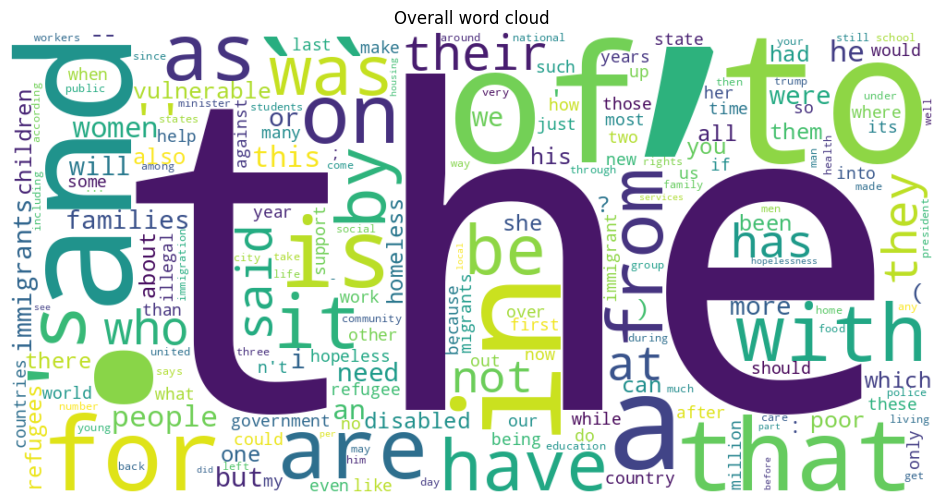

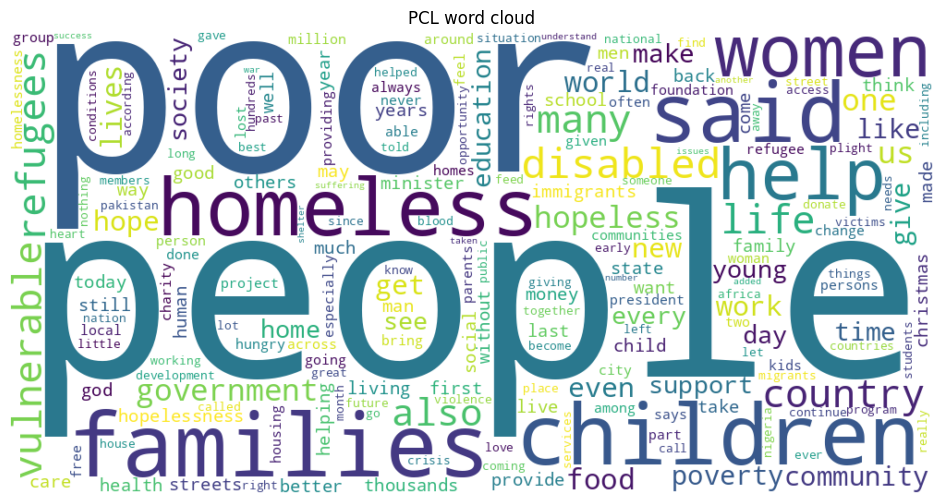

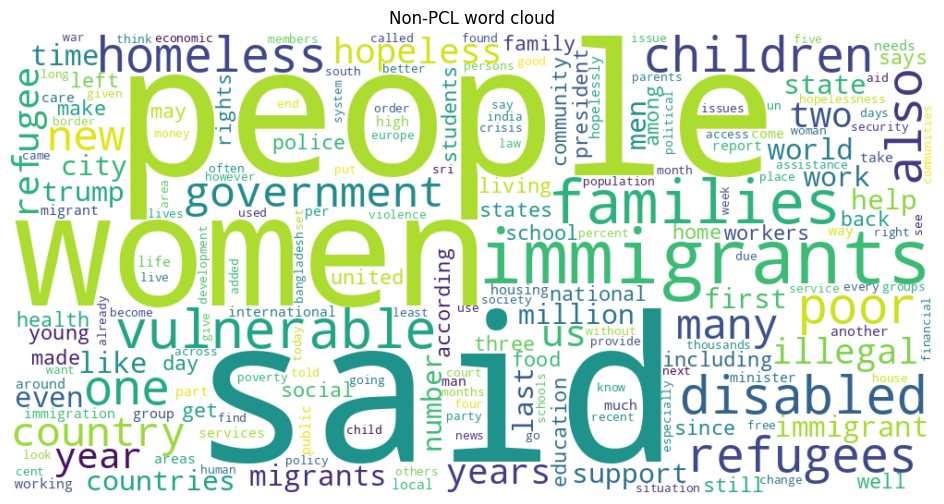

In [ ]:
# World clouds
# -------- Overall --------
wc_all = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(all_counts)

plt.figure(figsize=(14,6))
plt.imshow(wc_all, interpolation="bilinear")
plt.title("Overall word cloud")
plt.axis("off")
plt.show()


# -------- PCL --------
wc_pcl = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(pcl_counts)

plt.figure(figsize=(14,6))
plt.imshow(wc_pcl, interpolation="bilinear")
plt.title("PCL word cloud")
plt.axis("off")
plt.show()


# -------- Non-PCL --------
wc_non = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(non_pcl_counts)

plt.figure(figsize=(14,6))
plt.imshow(wc_non, interpolation="bilinear")
plt.title("Non-PCL word cloud")
plt.axis("off")
plt.show()

### Contrastive

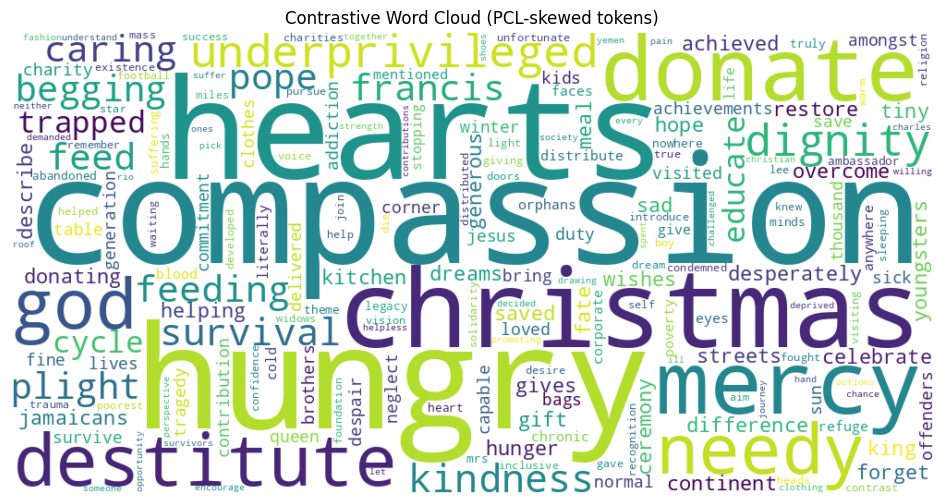

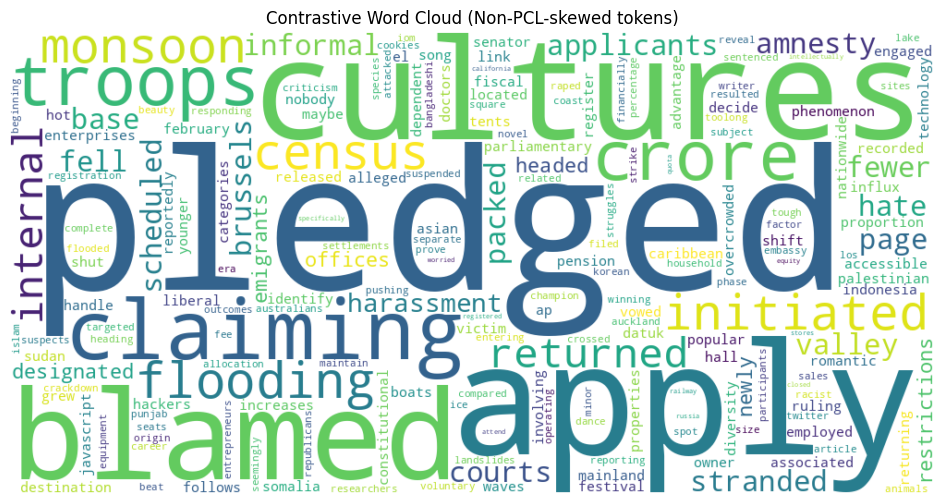

In [ ]:
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def count_tokens(token_lists):
    c = Counter()
    total = 0
    for toks in token_lists:
        c.update(toks)
        total += len(toks)
    return c, total

def contrastive_token_scores(df, alpha=1e-6, min_count=10):
    pcl_lists = df.loc[df["binary_label"] == 1, "nswp_tokens"]
    non_lists = df.loc[df["binary_label"] == 0, "nswp_tokens"]

    pcl_counts, pcl_total = count_tokens(pcl_lists)
    non_counts, non_total = count_tokens(non_lists)

    vocab = set(pcl_counts) | set(non_counts)

    scores = {}
    for w in vocab:
        pcl_c = pcl_counts.get(w, 0)
        non_c = non_counts.get(w, 0)

        if (pcl_c + non_c) < min_count:
            continue

        pcl_p = pcl_c / max(pcl_total, 1)
        non_p = non_c / max(non_total, 1)

        # log2 ratio: positive => PCL-skewed, negative => Non-PCL-skewed
        scores[w] = np.log2((pcl_p + alpha) / (non_p + alpha))

    return scores

scores = contrastive_token_scores(df, alpha=1e-6, min_count=15)

# Split into PCL-skewed and Non-PCL-skewed
pcl_scores = {w: s for w, s in scores.items() if s > 0}
non_scores = {w: -s for w, s in scores.items() if s < 0}  # flip sign so sizes are positive

# Optional: cap extreme values so a few words don't dominate
def cap_scores(d, cap=6.0):
    return {w: min(v, cap) for w, v in d.items()}

pcl_scores = cap_scores(pcl_scores, cap=6.0)
non_scores = cap_scores(non_scores, cap=6.0)

# ---- Generate word clouds ----
wc_pcl = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(pcl_scores)
plt.figure(figsize=(14,6))
plt.imshow(wc_pcl, interpolation="bilinear")
plt.title("Contrastive Word Cloud (PCL-skewed tokens)")
plt.axis("off")
plt.show()

wc_non = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(non_scores)
plt.figure(figsize=(14,6))
plt.imshow(wc_non, interpolation="bilinear")
plt.title("Contrastive Word Cloud (Non-PCL-skewed tokens)")
plt.axis("off")
plt.show()

# Semantic & Syntactic Exploration

### POS Tagging

POS distribution table:


,NOUN,VERB,OTHER,ADJ,PRON,ADV,MODAL
PCL,0.264593,0.151533,0.411843,0.072456,0.052313,0.036677,0.010586
Non-PCL,0.284319,0.145121,0.411258,0.078092,0.036696,0.035373,0.009141


<Figure size 1000x600 with 0 Axes>

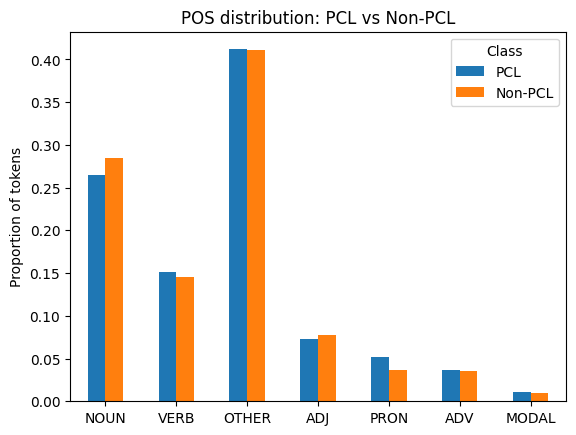

Total tokens analyzed: 509212
Sanity: POS tagging completed successfully.


In [ ]:
# ---------- map Penn POS → coarse linguistic categories ----------
def coarse_pos(tag):
    if tag.startswith("NN"):
        return "NOUN"
    if tag.startswith("VB"):
        return "VERB"
    if tag.startswith("JJ"):
        return "ADJ"
    if tag.startswith("RB"):
        return "ADV"
    if tag in ("PRP", "PRP$"):
        return "PRON"
    if tag == "MD":
        return "MODAL"
    return "OTHER"

# ---------- compute POS distributions ----------
def pos_distribution(token_lists):
    counter = Counter()
    total = 0

    for toks in token_lists:
        tagged = nltk.pos_tag(toks)
        for _, tag in tagged:
            counter[coarse_pos(tag)] += 1
            total += 1

    return {k: v / total for k, v in counter.items()}

# compute per class
pcl_pos = pos_distribution(df[df["binary_label"] == 1]["tokens"])
non_pos = pos_distribution(df[df["binary_label"] == 0]["tokens"])

# table
pos_df = pd.DataFrame([pcl_pos, non_pos], index=["PCL", "Non-PCL"]).fillna(0)

print("POS distribution table:")
display(pos_df)

# plot
plt.figure(figsize=(10,6))
pos_df.T.plot(kind="bar")
plt.title("POS distribution: PCL vs Non-PCL")
plt.ylabel("Proportion of tokens")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.show()

# sanity
total_tokens = df["tokens"].apply(len).sum()
print(f"Total tokens analyzed: {total_tokens}")
print("Sanity: POS tagging completed successfully.")

### NER

NER distribution (proportion of detected entities):


,PERSON,DATE,ORG,GPE,PERCENT,ORDINAL,CARDINAL,MONEY,NORP,TIME,LOC,QUANTITY,FAC,LANGUAGE,PRODUCT,WORK_OF_ART,EVENT,LAW
PCL,0.188031,0.145549,0.195789,0.165866,0.004433,0.019209,0.106760,0.009605,0.082379,0.012560,0.025120,0.005541,0.011452,0.003325,0.002586,0.012929,0.005541,0.003325
Non-PCL,0.150932,0.144486,0.189759,0.189395,0.010916,0.017970,0.131929,0.011311,0.087020,0.008696,0.022713,0.004591,0.007784,0.002280,0.003588,0.008574,0.005230,0.002828


<Figure size 1200x600 with 0 Axes>

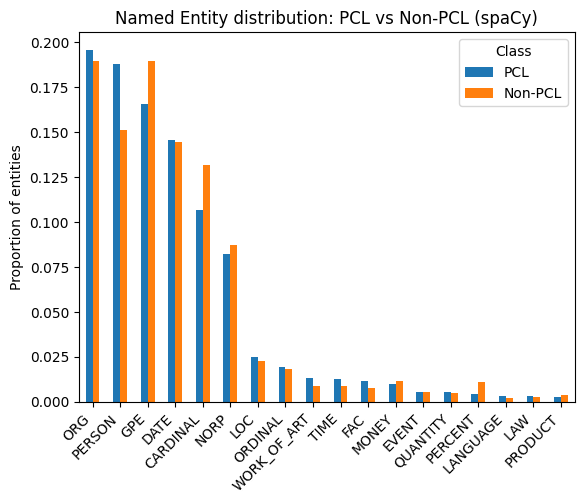

Total entities detected — PCL: 2707, Non-PCL: 32889


In [ ]:
nlp = spacy.load("en_core_web_sm")

def extract_entity_counts(texts):
    c = Counter()
    total = 0
    for doc in nlp.pipe(texts.astype(str), batch_size=64):
        for ent in doc.ents:
            c[ent.label_] += 1
            total += 1
    return c, total

# split by class
pcl_texts = df.loc[df["binary_label"] == 1, "text_clean"]
non_texts = df.loc[df["binary_label"] == 0, "text_clean"]

pcl_counts, pcl_total = extract_entity_counts(pcl_texts)
non_counts, non_total = extract_entity_counts(non_texts)

# normalize to proportions
pcl_dist = {k: v / pcl_total for k, v in pcl_counts.items()} if pcl_total else {}
non_dist = {k: v / non_total for k, v in non_counts.items()} if non_total else {}

ner_df = pd.DataFrame([pcl_dist, non_dist], index=["PCL", "Non-PCL"]).fillna(0)

print("NER distribution (proportion of detected entities):")
display(ner_df)

# plot (sorted by PCL proportion for readability)
plt.figure(figsize=(12, 6))
ner_df.T.sort_values("PCL", ascending=False).plot(kind="bar")
plt.title("Named Entity distribution: PCL vs Non-PCL (spaCy)")
plt.ylabel("Proportion of entities")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class")
plt.show()

# sanity
print(f"Total entities detected — PCL: {pcl_total}, Non-PCL: {non_total}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


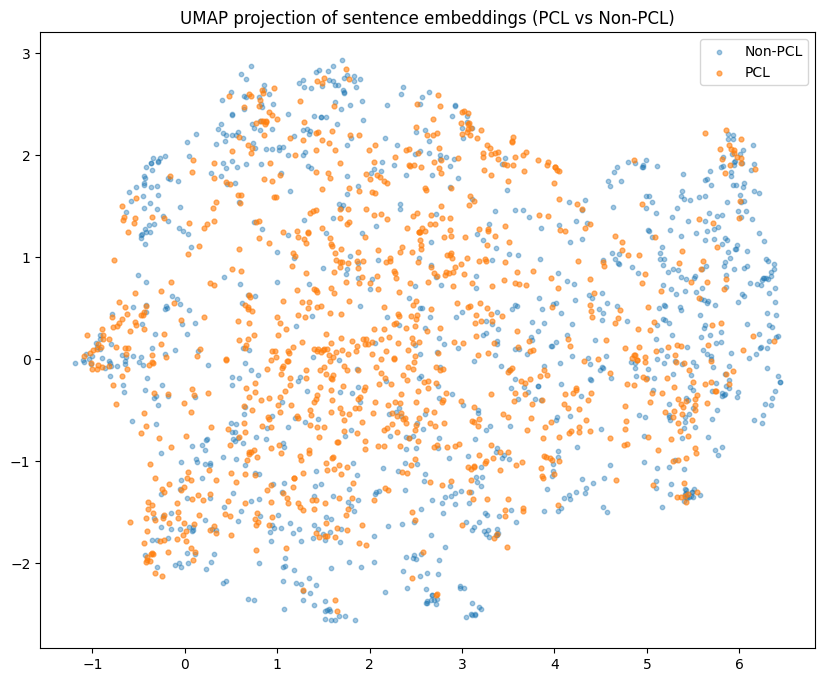

In [ ]:
# ---------- sample for speed ----------
N_PER_CLASS = len(df[df["binary_label"] == 1])

pcl_df = df[df["binary_label"] == 1].sample(n=min(N_PER_CLASS, (df["binary_label"] == 1).sum()), random_state=42)
non_df = df[df["binary_label"] == 0].sample(n=len(pcl_df), random_state=42)

sample_df = pd.concat([pcl_df, non_df]).sample(frac=1, random_state=42).reset_index(drop=True)

texts = sample_df["text_clean"].astype(str).tolist()
labels = sample_df["binary_label"].values

# ---------- compute embeddings ----------
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True
)

# ---------- reduce to 2D ----------
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

emb_2d = reducer.fit_transform(embeddings)

# ---------- plot ----------
plt.figure(figsize=(10,8))

plt.scatter(
    emb_2d[labels == 0, 0],
    emb_2d[labels == 0, 1],
    alpha=0.4,
    s=10,
    label="Non-PCL"
)

plt.scatter(
    emb_2d[labels == 1, 0],
    emb_2d[labels == 1, 1],
    alpha=0.6,
    s=12,
    label="PCL"
)

plt.title("UMAP projection of sentence embeddings (PCL vs Non-PCL)")
plt.legend()
plt.show()